----------------------------
#### Pretrained CNN model as a feature extractor with image augmentation

- Now, we will leverage a pretrained model that is basically an expert in the computer vision domain and renowned for image classification and categorization.
- we will also use image augmentation
-------------------------------------------

In [1]:
from IPython.display import Image

In [28]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import load_img, img_to_array, array_to_img

from random import sample, randint 

In [3]:
location_train = r'D:\MYLEARN\DATASETS\Images\dogs-vs-cats\train'

In [4]:
train_dir = location_train+'\\'+'training_data'
val_dir   = location_train+'\\'+'validation_data'

In [5]:
train_files = glob.glob(train_dir+'/*')

**Keras load_img**

|Arg        | Description                            |
|-------    | ---------------                        |
|path	    | Path to image file.                    |
|grayscale	| DEPRECATED use color_mode="grayscale". |
|color_mode	| One of "grayscale", "rgb", "rgba". Default: "rgb". The desired image format.|
|target_size| either None (default to original size) or tuple of ints (img_height, img_width).|
|interpolation	| Interpolation method used to resample the image if the target size is different from that of the loaded image. Supported methods are "nearest", "bilinear", and "bicubic". If PIL version 1.1.3 or newer is installed, "lanczos" is also supported. If PIL version 3.4.0 or newer is installed, "box" and "hamming" are also supported. By default, "nearest" is used.|

In [6]:
IMG_DIM = (150, 150)

<class 'PIL.JpegImagePlugin.JpegImageFile'> JPEG RGB (252, 335)


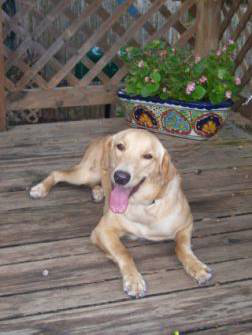

In [7]:
# load a random image
img = load_img(train_files[randint(0, len(train_files))])

# report details about the image
print(type(img), img.format, img.mode, img.size)

array_to_img(img)

We can confirm that the 
- image was loaded as a PIL image in JPEG format 
- with RGB channels and 
- the size of 640 by 427 pixels.... varying sizes

`load all training images `

- PIL image (jpeg)

In [8]:
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]

convert to numpy array

In [9]:
train_imgs = np.array(train_imgs)
train_imgs.shape

(3000, 150, 150, 3)

extract labels 

In [10]:
train_labels = [fn.split('.')[0].split('\\')[-1] for fn in train_files]
len(train_labels)

3000

`load validation samples`

In [11]:
validation_files = glob.glob(val_dir+'/*')

validation_imgs   = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs   = np.array(validation_imgs)
validation_labels = [fn.split('.')[0].split('\\')[-1] for fn in validation_files]
len(validation_labels)

1000

In [12]:
print('Train dataset shape:', train_imgs.shape, '\nValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (3000, 150, 150, 3) 
Validation dataset shape: (1000, 150, 150, 3)


- we have 3000 training images and 1000 validation images. 
- Each image is of size 150 x 150 and has 3 channels for red, green, and blue (RGB), hence giving each image the (150, 150, 3) dimensions. 
- We will now scale each image with pixel values between (0, 255) to values between (0, 1) because deep earning models work really well with small input values:

In [13]:
train_imgs_scaled      = train_imgs.astype('float32')
validation_imgs_scaled = validation_imgs.astype('float32')

train_imgs_scaled      /= 255
validation_imgs_scaled /= 255

print('Train dataset shape:', train_imgs_scaled.shape, '\nValidation dataset shape:', validation_imgs_scaled.shape)

Train dataset shape: (3000, 150, 150, 3) 
Validation dataset shape: (1000, 150, 150, 3)


(150, 150, 3)


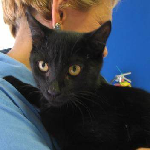

In [14]:
# visualize a sample image
print(train_imgs[0].shape)
array_to_img(train_imgs[25])

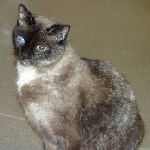

In [15]:
array_to_img(validation_imgs[15])

##### convert labels to numeric

In [16]:
batch_size  = 30
num_classes = 2
epochs      = 30
input_shape = (150, 150, 3)

In [17]:
# encode text category labels
from sklearn.preprocessing import LabelEncoder

In [18]:
le = LabelEncoder()
le.fit(train_labels)

train_labels_enc      = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

In [19]:
le.classes_

array(['cat', 'dog'], dtype='<U3')

In [20]:
print(train_labels[1495:1505], train_labels_enc[1495:1505])

['cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog'] [0 0 0 0 0 1 1 1 1 1]


#### load VGG model

In [21]:
from keras.applications import vgg16
from keras.models import Model
import keras

In [22]:
vgg = vgg16.VGG16(include_top = False, 
                  weights     = 'imagenet', 
                  input_shape = input_shape)

In [24]:
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)

In [26]:
vgg_model = Model(vgg.input, output)

vgg_model.trainable = True

set_trainable = False

for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
#print("Trainable layers:", vgg_model.trainable_weights)

In [29]:
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False


You can clearly see from the preceding output that the convolution and pooling layers pertaining to blocks 4 and 5 are now trainable, and you can also verify which layers are frozen and unfrozen using the following code:

In [30]:
import tensorflow
import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from tensorflow.keras import optimizers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [31]:
batch_size  = 30
num_classes = 2
epochs      = 30
input_shape = (150, 150, 3)

In [32]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

**define data generators**

In [34]:
from keras.preprocessing.image import ImageDataGenerator

In [35]:
train_datagen = ImageDataGenerator(rescale           = 1./255, 
                                   zoom_range        = 0.3, 
                                   rotation_range    = 50,
                                   width_shift_range = 0.2, 
                                   height_shift_range= 0.2, 
                                   shear_range       = 0.2, 
                                   horizontal_flip   = True, 
                                   fill_mode         = 'nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

**arguments of fit_generator**

|arg name      | description |
|--------------| ------------|
|`steps_per_epoch` | As the name suggests, here we can specify the number of steps performed after a single epoch is finished and  the next epoch starts.|
|`Epochs`          | This parameter helps in knowing the model number of iterations for training the model.|
|`Verbose`         | Through this parameter, we can show the status of our model training. If passed as ‘0’ i.e. silent, there will be not updates. If passed as ‘1’, then a progress bar is displayed. Lastly, if passed as ‘2’, then one output line will be displayed for each epoch.|
|`callbacks `       | This gives the information about number of callback functions applied for training the model.|

|argument name   | description                                 |
|----------------| ------------------------------------------- |
|`batch_size`      |determines the number of samples in each `mini batch`. Its maximum is the number of all samples, which makes gradient descent accurate, the loss will decrease towards the minimum if the learning rate is small enough, but iterations are slower. Its minimum is 1, resulting in stochastic gradient descent: Fast but the direction of the gradient step is based only on one example, the loss may jump around. batch_size allows to adjust between the two extremes: accurate gradient direction and fast iteration. Also, the maximum value for batch_size may be limited if your model + data set does not fit into the available (GPU) memory.|
|`steps_per_epoch` |the number of batch iterations before a training epoch is considered finished. If you have a training set of fixed size you can ignore it but it may be useful if you have a huge data set or if you are generating random data augmentations on the fly, i.e. if your training set has a (generated) infinite size. |
|`validation_steps` |similar to `steps_per_epoch` but on the `validation data set` instead on the training data. |

In [36]:
train_generator = train_datagen.flow(train_imgs, 
                                     train_labels_enc, 
                                     batch_size=32)

val_generator   = val_datagen.flow(validation_imgs, 
                                   validation_labels_enc, 
                                   batch_size=32)

input_shape = (150, 150, 3)

In [37]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

We will use the same data generators and model architecture as our previous model and train our model. We `reduce the learning rate ` slightly since we don't want to get stuck at any local minimal, and we also do not want to suddenly update the weights of the
trainable VGG-16 model layers by a big factor that might adversely affect the model:

In [39]:
input_shape = vgg_model.output_shape[1]

model = Sequential()

model.add(vgg_model)

model.add(InputLayer(input_shape=(input_shape,)))

model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss     = 'binary_crossentropy',
              optimizer= optimizers.RMSprop(learning_rate=2e-5),
              metrics  = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 8192)              14714688  
                                                                 
 input_3 (InputLayer)        multiple                  0         
                                                                 
 dense_3 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [40]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch  = 30, 
                              epochs           = 100,
                              validation_data  = val_generator, 
                              validation_steps = 30, 
                              verbose          = 1,
                              callbacks=[early_stop, tfdocs.modeling.EpochDots()])

C:\Users\v-bsinha\AppData\Local\Temp/ipykernel_10004/1787540640.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/100
30/30 [==============================] - ETA: 0s - loss: 0.6278 - accuracy: 0.6417 
Epoch: 0, accuracy:0.6417,  loss:0.6278,  val_accuracy:0.8146,  val_loss:0.4487,  
30/30 [==============================] - 975s 33s/step - loss: 0.6278 - accuracy: 0.6417 - val_loss: 0.4487 - val_accuracy: 0.8146
Epoch 2/100
30/30 [==============================] - 551s 18s/step - loss: 0.5151 - accuracy: 0.7604 - val_loss: 0.3243 - val_accuracy: 0.8792
Epoch 3/100
30/30 [==============================] - 481s 16s/step - loss: 0.4718 - accuracy: 0.7920 - val_loss: 0.3356 - val_accuracy: 0.8438
Epoch 4/100
30/30 [==============================] - 460s 15s/step - loss: 0.3732 - accuracy: 0.8393 - val_loss: 0.3083 - val_accuracy: 0.8729
Epoch 5/100
30/30 [==============================] - 445s 15s/step - loss: 0.3850 - accuracy: 0.8319 - val_loss: 0.2466 - val_accuracy: 0.9021
Epoch 6/100
30/30 [==============================] - 448s 15s/step - loss: 0.3637 - accuracy: 0.8323 - val_loss: 0.305

KeyboardInterrupt: 

We can see from the preceding output that our model has obtained a validation accuracy of around 96%, which is a 6% improvement from our previous model. 

Overall, this model has gained a 24% improvement in validation accuracy from our first basic CNN model. 

This really shows how useful transfer learning can be. 

Let's observe the model accuracy and loss plots:

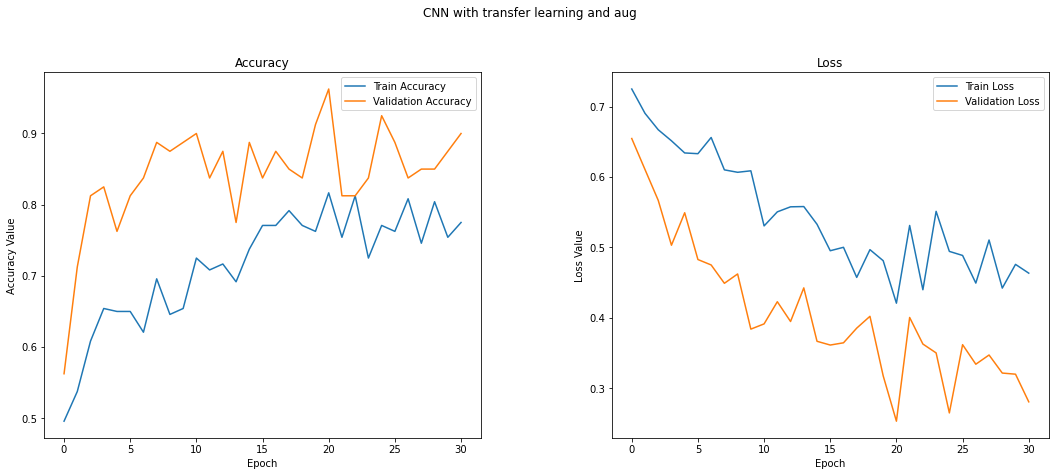

In [66]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
t = f.suptitle('CNN with transfer learning and aug', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = list(range(1,31))

ax1.plot(range(len(history.history['accuracy'])), history.history['accuracy'],     label='Train Accuracy')
ax1.plot(range(len(history.history['accuracy'])), history.history['val_accuracy'], label='Validation Accuracy')

ax1.set_xticks(np.arange(0, len(history.history['accuracy']), 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(range(len(history.history['accuracy'])), history.history['loss'],     label='Train Loss')
ax2.plot(range(len(history.history['accuracy'])), history.history['val_loss'], label='Validation Loss')

ax2.set_xticks(np.arange(0, len(history.history['accuracy']), 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

While there are some `spikes` in the `validation accuracy` and `loss`, overall, we see that it is much closer to the training accuracy, with the loss indicating that we obtained a model that generalizes much better as compared to our previous models. 

Training and validation accuracies are around 82%

Let's save this model now so we can evaluate it later on our test dataset:

#### Saving model/parameters

In [67]:
import pickle
import os

In [69]:
def model_save(model, encoder, model_save_path):
    _create_folder_if_it_doesnt_exist(model_save_path)
    _save_parameters(model_save_path)
    _save_weights(model_save_path)
    _save_encoder(model_save_path, encoder)

def _create_folder_if_it_doesnt_exist(model_save_path):
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)

def _save_parameters(model_save_path):
    parameters = [
        input_shape,
    ]
    save_parameters_file = os.path.join(model_save_path, "05_CNN_TL_aug_parameters.pkl")
    with open(save_parameters_file, "wb") as f:
        pickle.dump(parameters, f)

def _save_weights(model_save_path):
    save_weights_file = os.path.join(model_save_path, "05_CNN_TL_aug__weights.h5")
    model.save_weights(save_weights_file)
    
def _save_encoder(model_save_path, encoder):
    save_encoder_file = os.path.join(model_save_path, "05_CNN_TL_aug__encoder.pkl")
    with open(save_encoder_file, "wb") as f:
        pickle.dump(encoder, f)



In [70]:
model_save_path = './transfer_learning_models_save'

model_save(model=model, encoder=le, model_save_path=model_save_path)